# MLPF Final Project: Data Cleaning (Initial File)
## Project Title: Predicting Life Expectancy and Quality of Life
### Team Members: Meghan Holquist
#### Date: 4/4/2023

### 1.0 Executive summary

#### Description/Context of Problem:
There are a plethora of factors that impact overall life expectancy and quality of life, but the degree to which each of these factors impacts life expectancy varies. Often, life expectancy is determined based on medical history and general health behaviors such as smoking or drinking. However, many other factors such as environmental factors, stress levels, and socioeconomic factors can also influence an individual’s health. Through our analysis, we will aim to determine which factors are most influential in predicting life expectancy/quality. This can aid policymakers in their decisions on which policies to target to improve the overall health of their constituents.

#### Dataset Description
The University of Wisconsin’s Population Health Institute has created a dataset including information on health behaviors, clinical care, socioeconomic factors, and physical environment (air/water quality and transit information) on a county level for the United States. The data is aggregated from several sources including the Behavioral Risk Factor Surveillance System, the USDA food environment atlas, the National Center for Health Statistics, and the Bureau of Labor Statistics. We will be using data from the last 5 years (2019-2023)

#### Data overview
- Features 
    - General (all races) - most of them have low % of missing values
    - By race: black, white, hispanic, asian/pacific islander, aian) - high % missing values
- Indicator columns
   - state fips code
   - county fips code
   - 5-digit fips code
   - state abbreviation
   - name (same as 'state abbreviation')
   - release year
   - year

### 1.1 Table of contents and Imports

- Data cleaning
- Data vizualization
- Data modelling
- Conclusion
- References

In [1]:
# Load all libraries 

# Base libraries ---------------------------------------------------------
import numpy as np
import pandas as pd
import seaborn as sns
from matplotlib import pyplot as plt

# imblearn
import imblearn
from imblearn.over_sampling import (
    SMOTE, 
    RandomOverSampler,
)
from imblearn.under_sampling import (
    RandomUnderSampler, 
    TomekLinks,
)

# Sci-kit Learn ---------------------------------------------------------
from sklearn.feature_selection import SequentialFeatureSelector
from sklearn.linear_model import (
    LinearRegression, 
    LogisticRegression,
)
from sklearn.metrics import (
    mean_squared_error,
    confusion_matrix, 
    ConfusionMatrixDisplay, 
    classification_report, 
    roc_curve, 
    roc_auc_score,
)
from sklearn.model_selection import (
    train_test_split, 
    LeaveOneOut, 
    KFold, 
    cross_val_score,
    GridSearchCV
)
from sklearn.naive_bayes import (
    GaussianNB, 
    MultinomialNB,
    BernoulliNB,
)
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import (
    StandardScaler,
    OrdinalEncoder,
    OneHotEncoder,
)
import statsmodels.api as sm

# Yellowbrick ---------------------------------------------------------
import yellowbrick
from yellowbrick.classifier.rocauc import roc_auc
from yellowbrick.classifier import (
    ClassificationReport,
    ConfusionMatrix,
    ROCAUC,
    ClassPredictionError,
)

pd.options.display.max_rows = 4000

In [2]:
SEED = 1234
TEST_SIZE = 0.2

### 1.2 Data cleaning

#### Importing and merging
The first step in the cleaning process is to ensure all the columns are the same across years so we can properly merge them. After looking at the data documentation, there were no measures that changed names across years, so we can focus on identifying only the columns that are in common across all years. For this, we use an inner join.

In [153]:
# Read the files
df_2018 = pd.read_csv('../data/analytic_data2018.csv', low_memory=False, skiprows=[1])
df_2019 = pd.read_csv('../data/analytic_data2019.csv', low_memory=False, skiprows=[1])
df_2020 = pd.read_csv('../data/analytic_data2020.csv', low_memory=False, skiprows=[1])
df_2021 = pd.read_csv('../data/analytic_data2021.csv', low_memory=False, skiprows=[1])
df_2022 = pd.read_csv('../data/analytic_data2022.csv', low_memory=False, skiprows=[1])
df_2023 = pd.read_csv('../data/analytic_data2023.csv', low_memory=False, skiprows=[1])

# Assign a column year to each dataset 
# df_2018['Year'] = '2018'
# df_2019['Year'] = '2019'
# df_2020['Year'] = '2020'
# df_2021['Year'] = '2021'
# df_2022['Year'] = '2022'
# df_2023['Year'] = '2023'

# Make all columns lowercase (helped to deal with 50% of mistyped columns (e.g., White vs white))
df_2018.columns= df_2018.columns.str.lower()
df_2019.columns= df_2019.columns.str.lower()
df_2020.columns= df_2020.columns.str.lower()
df_2021.columns= df_2021.columns.str.lower()
df_2022.columns= df_2022.columns.str.lower()
df_2023.columns= df_2023.columns.str.lower()

# Rename columns
df_2018.rename(columns = {
    '% american indian & alaska native raw value':'% american indian and alaskan native raw value',
    '% american indian and alaskan native raw value': '% american indian and alaskan native raw value',
    '% american indian or alaska native raw value': '% american indian and alaskan native raw value',
    '% females raw value':'% female', 
    '% female raw value':'% female',
    '% native hawaiian or other pacific islander raw value':'% native hawaiian or other pacific islander raw value',
    '% native hawaiian/other pacific islander raw value':'% native hawaiian or other pacific islander raw value',
    '% non-hispanic african american raw value':'% non-hispanic black raw value',
    'ratio of population to dentists.':'ratio of population to dentists',
    'ratio of population to mental health providers.':'ratio of population to mental health providers',
    'ratio of population to primary care physicians.':'ratio of population to primary care physicians.',
    '% female raw value':'% female',
    'ratio of population to primary care physicians.':'ratio of population to primary care physicians',
    'ratio of population to primary care providers other than physicians.':'ratio of population to primary care providers other than physicians'
}, inplace = True)

df_2019.rename(columns = {'% american indian or alaska native raw value': '% american indian and alaskan native raw value','% american indian & alaska native raw value':'% american indian and alaskan native raw value', '% american indian and alaskan native raw value': '% american indian and alaskan native raw value','% females raw value':'% female',  '% female raw value':'% female','% native hawaiian or other pacific islander raw value':'% native hawaiian or other pacific islander raw value','% native hawaiian/other pacific islander raw value':'% native hawaiian or other pacific islander raw value','% non-hispanic african american raw value':'% non-hispanic black raw value','ratio of population to dentists.':'ratio of population to dentists','ratio of population to mental health providers.':'ratio of population to mental health providers','ratio of population to primary care physicians.':'ratio of population to primary care physicians.','% female raw value':'% female','ratio of population to primary care physicians.':'ratio of population to primary care physicians','ratio of population to primary care providers other than physicians.':'ratio of population to primary care providers other than physicians'}, inplace = True)
df_2020.rename(columns = {'% american indian or alaska native raw value': '% american indian and alaskan native raw value','% american indian & alaska native raw value':'% american indian and alaskan native raw value', '% american indian and alaskan native raw value': '% american indian and alaskan native raw value','% females raw value':'% female',  '% female raw value':'% female','% native hawaiian or other pacific islander raw value':'% native hawaiian or other pacific islander raw value','% native hawaiian/other pacific islander raw value':'% native hawaiian or other pacific islander raw value','% non-hispanic african american raw value':'% non-hispanic black raw value','ratio of population to dentists.':'ratio of population to dentists','ratio of population to mental health providers.':'ratio of population to mental health providers','ratio of population to primary care physicians.':'ratio of population to primary care physicians.','% female raw value':'% female','ratio of population to primary care physicians.':'ratio of population to primary care physicians','ratio of population to primary care providers other than physicians.':'ratio of population to primary care providers other than physicians'}, inplace = True)
df_2021.rename(columns = {'% american indian or alaska native raw value': '% american indian and alaskan native raw value','% american indian & alaska native raw value':'% american indian and alaskan native raw value', '% american indian and alaskan native raw value': '% american indian and alaskan native raw value','% females raw value':'% female',  '% female raw value':'% female','% native hawaiian or other pacific islander raw value':'% native hawaiian or other pacific islander raw value','% native hawaiian/other pacific islander raw value':'% native hawaiian or other pacific islander raw value','% non-hispanic african american raw value':'% non-hispanic black raw value','ratio of population to dentists.':'ratio of population to dentists','ratio of population to mental health providers.':'ratio of population to mental health providers','ratio of population to primary care physicians.':'ratio of population to primary care physicians.','% female raw value':'% female','ratio of population to primary care physicians.':'ratio of population to primary care physicians','ratio of population to primary care providers other than physicians.':'ratio of population to primary care providers other than physicians'}, inplace = True)
df_2022.rename(columns = {'% american indian or alaska native raw value': '% american indian and alaskan native raw value','% american indian & alaska native raw value':'% american indian and alaskan native raw value', '% american indian and alaskan native raw value': '% american indian and alaskan native raw value','% females raw value':'% female',  '% female raw value':'% female','% native hawaiian or other pacific islander raw value':'% native hawaiian or other pacific islander raw value','% native hawaiian/other pacific islander raw value':'% native hawaiian or other pacific islander raw value','% non-hispanic african american raw value':'% non-hispanic black raw value','ratio of population to dentists.':'ratio of population to dentists','ratio of population to mental health providers.':'ratio of population to mental health providers','ratio of population to primary care physicians.':'ratio of population to primary care physicians.','% female raw value':'% female','ratio of population to primary care physicians.':'ratio of population to primary care physicians','ratio of population to primary care providers other than physicians.':'ratio of population to primary care providers other than physicians'}, inplace = True)
df_2023.rename(columns = {'% american indian or alaska native raw value': '% american indian and alaskan native raw value','% american indian & alaska native raw value':'% american indian and alaskan native raw value', '% american indian and alaskan native raw value': '% american indian and alaskan native raw value','% females raw value':'% female',  '% female raw value':'% female','% native hawaiian or other pacific islander raw value':'% native hawaiian or other pacific islander raw value','% native hawaiian/other pacific islander raw value':'% native hawaiian or other pacific islander raw value','% non-hispanic african american raw value':'% non-hispanic black raw value','ratio of population to dentists.':'ratio of population to dentists','ratio of population to mental health providers.':'ratio of population to mental health providers','ratio of population to primary care physicians.':'ratio of population to primary care physicians.','% female raw value':'% female','ratio of population to primary care physicians.':'ratio of population to primary care physicians','ratio of population to primary care providers other than physicians.':'ratio of population to primary care providers other than physicians'}, inplace = True)

In [154]:
# Merge datasets into one
frames = [df_2019, df_2020, df_2021, df_2022, df_2023]
df = pd.concat(frames, join='inner', ignore_index=True)
print(f"Shape of joined df: {df.shape}")
df.head()

Shape of joined df: (15970, 387)


,state fips code,county fips code,5-digit fips code,state abbreviation,name,release year,county ranked (yes=1/no=0),premature death raw value,premature death numerator,premature death denominator,...,% not proficient in english numerator,% not proficient in english denominator,% not proficient in english ci low,% not proficient in english ci high,% female,% rural raw value,% rural numerator,% rural denominator,% rural ci low,% rural ci high
0,0,0,0,US,United States,2019,NaN,6900.630354,3745538.0,908266078.0,...,13417454,301150892,0.044322,0.044786,0.507526,NaN,NaN,NaN,NaN,NaN
1,1,0,1000,AL,Alabama,2019,NaN,9917.232898,80440.0,13636816.0,...,48998,4558608,0.010208,0.011289,0.515906,0.409632,1957932.0,4779736.0,NaN,NaN
2,1,1,1001,AL,Autauga County,2019,1.0,8824.057123,815.0,156132.0,...,430,51898,0.004225,0.012346,0.513422,0.420022,22921.0,54571.0,NaN,NaN
3,1,3,1003,AL,Baldwin County,2019,1.0,7224.632160,2827.0,576496.0,...,872,191854,0.002821,0.006269,0.514528,0.422791,77060.0,182265.0,NaN,NaN
4,1,5,1005,AL,Barbour County,2019,1.0,9586.165037,451.0,72222.0,...,297,24765,0.005805,0.018180,0.472299,0.677896,18613.0,27457.0,NaN,NaN


In [155]:
# Confirm that the shape of the dataframe we end up with matches our expectation
df_2019_cols = set(df_2019.columns)
df_2020_cols = set(df_2020.columns)
df_2021_cols = set(df_2021.columns)
df_2022_cols = set(df_2022.columns)
df_2023_cols = set(df_2023.columns)

common_cols = df_2019_cols.intersection(df_2020_cols, df_2021_cols, df_2022_cols, df_2023_cols)

print(len(list(common_cols)))
print(df.shape[-1])

387
387


### Creating multi-index

In [156]:
id_cols = [
    'state fips code',
    'county fips code',
    '5-digit fips code', 
    'state abbreviation',
    'name',
    'release year',
]

print(f"# Cols: {df.shape[-1]}")
print(f"# Non-ID Cols: {len(list(df.columns.difference(id_cols)))}")
print(f"# ID cols: {len(id_cols)}")

assert df.shape[-1] == len(list(df.columns.difference(id_cols))) + len(id_cols)

# Cols: 387
# Non-ID Cols: 381
# ID cols: 6


In [157]:
multi_index = pd.MultiIndex.from_frame(df.loc[:, id_cols])
df.index = multi_index
df.drop(columns=id_cols, inplace=True)
df.head()

county ranked (yes=1/no=0)  \
state fips code county fips code 5-digit fips code state abbreviation name           release year                               
0               0                0                 US                 United States  2019                                 NaN   
1               0                1000              AL                 Alabama        2019                                 NaN   
                1                1001              AL                 Autauga County 2019                                 1.0   
                3                1003              AL                 Baldwin County 2019                                 1.0   
                5                1005              AL                 Barbour County 2019                                 1.0   

                                                                                                   premature death raw value  \
state fips code county fips code 5-digit fips code state abbreviation name           release year                              
0               0                0                 US                 United States  2019                        6900.630354   
1               0                1000              AL                 Alabama        2019                        9917.232898   
                1                1001              AL                 Autauga County 2019                        8824.057123   
                3                1003              AL                 Baldwin County 2019                        7224.632160   
                5                1005              AL                 Barbour County 2019                        9586.165037   

                                                                                                   premature death numerator  \
state fips code county fips code 5-digit fips code state abbreviation name           release year                              
0               0                0                 US                 United States  2019                          3745538.0   
1               0                1000              AL                 Alabama        2019                            80440.0   
                1                1001              AL                 Autauga County 2019                              815.0   
                3                1003              AL                 Baldwin County 2019                             2827.0   
                5                1005              AL                 Barbour County 2019                              451.0   

                                                                                                   premature death denominator  \
state fips code county fips code 5-digit fips code state abbreviation name           release year                                
0               0                0                 US                 United States  2019                          908266078.0   
1               0                1000              AL                 Alabama        2019                           13636816.0   
                1                1001              AL                 Autauga County 2019                             156132.0   
                3                1003              AL                 Baldwin County 2019                             576496.0   
                5                1005              AL                 Barbour County 2019                              72222.0   

                                                                                                   premature death ci low  \
state fips code county fips code 5-digit fips code state abbreviation name           release year                           
0               0                0                 US                 United States  2019                     6890.349206   
1               0                1000              AL                 Alabama        2019                     9815.

### Dropping Irrelevant Columns

Now that we haave properly merged all of our data across years, we can now look at which columns we want to keep/drop. Many columns have numerator, denominator, or confidence interval values. We will drop these columns as they will not be valuable in our modelling; we only want to use the raw values for our models.

We don't believe we will gain much explanatory power from the CI and numerator/denominator data, so we drop here. This type of data might be more useful for some kind of sensitivity analysis, which we are not interested in here. 

In [158]:
# Drop all columns with "CI low", "CI high", "numerator", "denominator" 

print("-------------------------------")
print(f"Shape before: {df.shape}")

df = df[df.columns.drop(list(df.filter(regex='ci low')))]
df = df[df.columns.drop(list(df.filter(regex='ci high')))]
df = df[df.columns.drop(list(df.filter(regex='numerator')))]
df = df[df.columns.drop(list(df.filter(regex='denominator')))]
df = df.drop(columns=['county ranked (yes=1/no=0)']) # To check df[df['county ranked (yes=1/no=0)'] != 1]

print(f"Shape before: {df.shape}")
print("-------------------------------")

df.head()

-------------------------------
Shape before: (15970, 381)
Shape before: (15970, 116)
-------------------------------


premature death raw value  \
state fips code county fips code 5-digit fips code state abbreviation name           release year                              
0               0                0                 US                 United States  2019                        6900.630354   
1               0                1000              AL                 Alabama        2019                        9917.232898   
                1                1001              AL                 Autauga County 2019                        8824.057123   
                3                1003              AL                 Baldwin County 2019                        7224.632160   
                5                1005              AL                 Barbour County 2019                        9586.165037   

                                                                                                   premature death (black)  \
state fips code county fips code 5-digit fips code state abbreviation name           release year                            
0               0                0                 US                 United States  2019                              NaN   
1               0                1000              AL                 Alabama        2019                              NaN   
                1                1001              AL                 Autauga County 2019                     10471.252986   
                3                1003              AL                 Baldwin County 2019                     10042.472874   
                5                1005              AL                 Barbour County 2019                     11332.562909   

                                                                                                   premature death (hispanic)  \
state fips code county fips code 5-digit fips code state abbreviation name           release year                               
0               0                0                 US                 United States  2019                                 NaN   
1               0                1000              AL                 Alabama        2019                                 NaN   
                1                1001              AL                 Autauga County 2019                                 NaN   
                3                1003              AL                 Baldwin County 2019                         3086.605695   
                5                1005              AL                 Barbour County 2019                                 NaN   

                                                                                                   premature death (white)  \
state fips code county fips code 5-digit fips code state abbreviation name           release year                            
0               0                0                 US                 United States  2019                              NaN   
1               0                1000              AL                 Alabama        2019                              NaN   
                1                1001              AL                 Autauga County 2019                      8706.658832   
                3                1003              AL                 Baldwin County 2019                      7277.780727   
                5                1005              AL                 Barbour County 2019                      7309.636719   

                                                                                                   poor or fair health raw value  \
state fips code county fips code 5-digit fips code state abbreviation name           release year                                  
0               0                0                 US                 United States  2019                                    NaN   
1               0                1000              AL                 Alabama        2019                               0.214024   
    

#### Race-specific columns
Many of the columns with high missing values are those that are race-specific. Additionally, these race columns are going to be highly correlated with the overall county raw value. For these reasons, we are choosing to drop all race-specific columns. 

In [159]:
print("-------------------------------")
print(f"Shape before: {df.shape}")

#Filter out the race-specific columns
df = df[df.columns.drop(list(df.filter(regex='white')))]
df = df[df.columns.drop(list(df.filter(regex='black')))]
df = df[df.columns.drop(list(df.filter(regex='hispanic')))]
df = df[df.columns.drop(list(df.filter(regex='asian')))]
df = df[df.columns.drop(list(df.filter(regex='native')))]

print(f"Shape before: {df.shape}")
print("-------------------------------")

df.head()

-------------------------------
Shape before: (15970, 116)
Shape before: (15970, 70)
-------------------------------


premature death raw value  \
state fips code county fips code 5-digit fips code state abbreviation name           release year                              
0               0                0                 US                 United States  2019                        6900.630354   
1               0                1000              AL                 Alabama        2019                        9917.232898   
                1                1001              AL                 Autauga County 2019                        8824.057123   
                3                1003              AL                 Baldwin County 2019                        7224.632160   
                5                1005              AL                 Barbour County 2019                        9586.165037   

                                                                                                   poor or fair health raw value  \
state fips code county fips code 5-digit fips code state abbreviation name           release year                                  
0               0                0                 US                 United States  2019                                    NaN   
1               0                1000              AL                 Alabama        2019                               0.214024   
                1                1001              AL                 Autauga County 2019                               0.184111   
                3                1003              AL                 Baldwin County 2019                               0.180605   
                5                1005              AL                 Barbour County 2019                               0.257734   

                                                                                                   poor physical health days raw value  \
state fips code county fips code 5-digit fips code state abbreviation name           release year                                        
0               0                0                 US                 United States  2019                                          NaN   
1               0                1000              AL                 Alabama        2019                                     4.400458   
                1                1001              AL                 Autauga County 2019                                     4.200578   
                3                1003              AL                 Baldwin County 2019                                     4.098748   
                5                1005              AL                 Barbour County 2019                                     5.067438   

                                                                                                   poor mental health days raw value  \
state fips code county fips code 5-digit fips code state abbreviation name           release year                                      
0               0                0                 US                 United States  2019                                        NaN   
1               0                1000              AL                 Alabama        2019                                   4.577367   
                1                1001              AL                 Autauga County 2019                                   4.306739   
                3                1003              AL                 Baldwin County 2019                                   4.249649   
                5                1005              AL                 Barbour County 2019                                   4.634994   

                                                                                                   low birthweight raw value  \
state fips code county fips code 5-digit fips code state abbreviation name           release year                              
0               0                0                 US                 United States  2019            

In [160]:
#Now we check for missing values
percent_missing = (df.isnull().sum()/ len(df)) *100
missing_value_df = pd.DataFrame({'percent_missing': percent_missing})
missing_value_df.sort_values('percent_missing', inplace=True)

#only going to check the ones with > 0 percent so we can easily tell which ones we need to deal with. 
missing_columns = missing_value_df[missing_value_df['percent_missing'] > 0]
missing_columns

,percent_missing
long commute - driving alone raw value,0.006262
physical inactivity raw value,0.012523
adult obesity raw value,0.012523
driving alone to work raw value,0.012523
diabetes prevalence raw value,0.012523
poor or fair health raw value,0.018785
frequent physical distress raw value,0.018785
frequent mental distress raw value,0.018785
poor physical health days raw value,0.018785
poor mental health days raw value,0.018785


#### Other columns with missing values. 
We now need to decide how to deal with the other columns that have a high percentage of missing values. 
 - **For columns with > 20% missing values:**  
     - For those columns with a high percentaage of missing values, we examined if they were missing on a county level and whether it was the same counties consistently missing the data. Unfortunately we found that it was the same counties with these missing values each year, but some counties are not missing all of these columns they're only missing 1. For example it might just be they are missing homicides and have full data for the rest of the columns. Therefore, If we were to drop specific counties based on which had missing values, it would remove too much data. 
     - For these reasons we are deciding to completely drop those columns with > 20% missing values, and base our models only on the data we have. This way we preserve most of the original structure of our data. 
 - **For columns with < 20% missing values:** 
     - We are choosing to impute these missing values with the average from each county. 
     - We have data for each county in the US across 5 years. If a county is missing a particular value, they likely are missing that value for the rest of the years as well. However, not all of these counties have all years missing for every column. For those that have at least one year of data per column, we are filling with the average from other years. 
     - The alternative would be to fill the county-level missing value with the state average. However, this is an issue because counties are not necesarily representative of the rest of the state, and vice versa. We believe it would be making too many assumtions to fill the county-level data with state-level data. However, if there are counties that do not have any data for that column in any year, we will need to fill it with the state average. 

In [161]:
#Drop columns with > 20% missing values

#Grab columns with > 20% missing
high_missing = missing_columns[missing_columns['percent_missing'] > 20].index.tolist()

#Filter them from df
df = df.loc[:, df.columns.difference(high_missing)]
df.head()

% 65 and older raw value  \
state fips code county fips code 5-digit fips code state abbreviation name           release year                             
0               0                0                 US                 United States  2019                          0.156143   
1               0                1000              AL                 Alabama        2019                          0.164885   
                1                1001              AL                 Autauga County 2019                          0.151196   
                3                1003              AL                 Baldwin County 2019                          0.199470   
                5                1005              AL                 Barbour County 2019                          0.188247   

                                                                                                   % below 18 years of age raw value  \
state fips code county fips code 5-digit fips code state abbreviation name           release year                                      
0               0                0                 US                 United States  2019                                   0.226132   
1               0                1000              AL                 Alabama        2019                                   0.224724   
                1                1001              AL                 Autauga County 2019                                   0.239370   
                3                1003              AL                 Baldwin County 2019                                   0.218485   
                5                1005              AL                 Barbour County 2019                                   0.207638   

                                                                                                   % female  \
state fips code county fips code 5-digit fips code state abbreviation name           release year             
0               0                0                 US                 United States  2019          0.507526   
1               0                1000              AL                 Alabama        2019          0.515906   
                1                1001              AL                 Autauga County 2019          0.513422   
                3                1003              AL                 Baldwin County 2019          0.514528   
                5                1005              AL                 Barbour County 2019          0.472299   

                                                                                                   % not proficient in english raw value  \
state fips code county fips code 5-digit fips code state abbreviation name           release year                                          
0               0                0                 US                 United States  2019                                       0.044554   
1               0                1000              AL                 Alabama        2019                                       0.010748   
                1                1001              AL                 Autauga County 2019                                       0.008285   
                3                1003              AL                 Baldwin County 2019                                       0.004545   
                5                1005              AL                 Barbour County 2019                                       0.011993   

                                                                                                   % rural raw value  \
state fips code county fips code 5-digit fips code state abbreviation name           release year                      
0               0                0                 US                 United States  2019                        NaN   
1               0                1000              AL                 Alabama        2019                   0.409632   
                1

In [162]:
#Now we impute the other missing values
#group by the county
#using fips code bc its a unique identifier- counties can have same name across states

df_imputed = df.copy()
df_imputed = df.groupby(['5-digit fips code']).transform(lambda x: x.fillna(x.mean()))

df_imputed.head()

% 65 and older raw value  \
state fips code county fips code 5-digit fips code state abbreviation name           release year                             
0               0                0                 US                 United States  2019                          0.156143   
1               0                1000              AL                 Alabama        2019                          0.164885   
                1                1001              AL                 Autauga County 2019                          0.151196   
                3                1003              AL                 Baldwin County 2019                          0.199470   
                5                1005              AL                 Barbour County 2019                          0.188247   

                                                                                                   % below 18 years of age raw value  \
state fips code county fips code 5-digit fips code state abbreviation name           release year                                      
0               0                0                 US                 United States  2019                                   0.226132   
1               0                1000              AL                 Alabama        2019                                   0.224724   
                1                1001              AL                 Autauga County 2019                                   0.239370   
                3                1003              AL                 Baldwin County 2019                                   0.218485   
                5                1005              AL                 Barbour County 2019                                   0.207638   

                                                                                                   % female  \
state fips code county fips code 5-digit fips code state abbreviation name           release year             
0               0                0                 US                 United States  2019          0.507526   
1               0                1000              AL                 Alabama        2019          0.515906   
                1                1001              AL                 Autauga County 2019          0.513422   
                3                1003              AL                 Baldwin County 2019          0.514528   
                5                1005              AL                 Barbour County 2019          0.472299   

                                                                                                   % not proficient in english raw value  \
state fips code county fips code 5-digit fips code state abbreviation name           release year                                          
0               0                0                 US                 United States  2019                                       0.044554   
1               0                1000              AL                 Alabama        2019                                       0.010748   
                1                1001              AL                 Autauga County 2019                                       0.008285   
                3                1003              AL                 Baldwin County 2019                                       0.004545   
                5                1005              AL                 Barbour County 2019                                       0.011993   

                                                                                                   % rural raw value  \
state fips code county fips code 5-digit fips code state abbreviation name           release year                      
0               0                0                 US                 United States  2019                   0.192768   
1               0                1000              AL                 Alabama        2019                   0.409632   
                1

In [163]:
#check the rest of the missing 
#these will be missing values for counties that have no data from previous years,
#so now we are going to fill them with the state average. 
percent_missing = (df_imputed.isnull().sum()/ len(df_imputed)) *100
missing_value_df = pd.DataFrame({'percent_missing': percent_missing})
missing_value_df.sort_values('percent_missing', inplace=True)
missing_value_df[missing_value_df['percent_missing'] > 0]

,percent_missing
severe housing cost burden raw value,0.031309
unemployment raw value,0.031309
uninsured adults raw value,0.031309
median household income raw value,0.031309
uninsured raw value,0.031309
uninsured children raw value,0.031309
children in poverty raw value,0.031309
children in single-parent households raw value,0.031309
% rural raw value,0.219161
other primary care providers raw value,0.281778


In [164]:
#Now we need to fill the rest of the nas with the state average
#group by the state

df_imputed = df.copy()
df_imputed = df.groupby(['state fips code']).transform(lambda x: x.fillna(x.mean()))

df_imputed.head()

% 65 and older raw value  \
state fips code county fips code 5-digit fips code state abbreviation name           release year                             
0               0                0                 US                 United States  2019                          0.156143   
1               0                1000              AL                 Alabama        2019                          0.164885   
                1                1001              AL                 Autauga County 2019                          0.151196   
                3                1003              AL                 Baldwin County 2019                          0.199470   
                5                1005              AL                 Barbour County 2019                          0.188247   

                                                                                                   % below 18 years of age raw value  \
state fips code county fips code 5-digit fips code state abbreviation name           release year                                      
0               0                0                 US                 United States  2019                                   0.226132   
1               0                1000              AL                 Alabama        2019                                   0.224724   
                1                1001              AL                 Autauga County 2019                                   0.239370   
                3                1003              AL                 Baldwin County 2019                                   0.218485   
                5                1005              AL                 Barbour County 2019                                   0.207638   

                                                                                                   % female  \
state fips code county fips code 5-digit fips code state abbreviation name           release year             
0               0                0                 US                 United States  2019          0.507526   
1               0                1000              AL                 Alabama        2019          0.515906   
                1                1001              AL                 Autauga County 2019          0.513422   
                3                1003              AL                 Baldwin County 2019          0.514528   
                5                1005              AL                 Barbour County 2019          0.472299   

                                                                                                   % not proficient in english raw value  \
state fips code county fips code 5-digit fips code state abbreviation name           release year                                          
0               0                0                 US                 United States  2019                                       0.044554   
1               0                1000              AL                 Alabama        2019                                       0.010748   
                1                1001              AL                 Autauga County 2019                                       0.008285   
                3                1003              AL                 Baldwin County 2019                                       0.004545   
                5                1005              AL                 Barbour County 2019                                       0.011993   

                                                                                                   % rural raw value  \
state fips code county fips code 5-digit fips code state abbreviation name           release year                      
0               0                0                 US                 United States  2019                   0.192768   
1               0                1000              AL                 Alabama        2019                   0.409632   
                1

In [165]:
#checking again
percent_missing = (df_imputed.isnull().sum()/ len(df_imputed)) *100
missing_value_df = pd.DataFrame({'percent_missing': percent_missing})
missing_value_df.sort_values('percent_missing', inplace=True)
missing_value_df[missing_value_df['percent_missing'] > 0]

#these must be states that dont have this info for some reason, its such a small pct we can just drop the rows. 

,percent_missing
drinking water violations raw value,0.187852
children eligible for free or reduced price lunch raw value,0.657483


In [166]:
df_imputed = df_imputed.dropna()
df_imputed.shape

(15835, 63)

In [167]:
# Check the missing values 
percent_missing = (df_imputed.isnull().sum()/ len(df_imputed)) *100
missing_value_df = pd.DataFrame({'percent_missing': percent_missing})
missing_value_df.sort_values('percent_missing', inplace=True)
missing_value_df[missing_value_df['percent_missing'] > 0]

,percent_missing


Here, we confirm that no missing values remain. In an initial iteration, there were three remaining columns that still had a large number of missing values. We have simply commented out that code below.

### Remove non-county observations

In [168]:
# Get the level index of the county fips code
county_fips_level_idx = list(df_imputed.index.names).index('county fips code')
county_fips_level_idx

1

In [169]:
# Get the indices where the county fips code != 0
county_idx = df_imputed.index.get_level_values(county_fips_level_idx) != 0

# Filter out non-county data
df_clean = df_imputed.loc[county_idx, :]
print(df_clean.shape)
df_clean.head()

(15595, 63)


% 65 and older raw value  \
state fips code county fips code 5-digit fips code state abbreviation name           release year                             
1               1                1001              AL                 Autauga County 2019                          0.151196   
                3                1003              AL                 Baldwin County 2019                          0.199470   
                5                1005              AL                 Barbour County 2019                          0.188247   
                7                1007              AL                 Bibb County    2019                          0.160226   
                9                1009              AL                 Blount County  2019                          0.178426   

                                                                                                   % below 18 years of age raw value  \
state fips code county fips code 5-digit fips code state abbreviation name           release year                                      
1               1                1001              AL                 Autauga County 2019                                   0.239370   
                3                1003              AL                 Baldwin County 2019                                   0.218485   
                5                1005              AL                 Barbour County 2019                                   0.207638   
                7                1007              AL                 Bibb County    2019                                   0.206061   
                9                1009              AL                 Blount County  2019                                   0.233499   

                                                                                                   % female  \
state fips code county fips code 5-digit fips code state abbreviation name           release year             
1               1                1001              AL                 Autauga County 2019          0.513422   
                3                1003              AL                 Baldwin County 2019          0.514528   
                5                1005              AL                 Barbour County 2019          0.472299   
                7                1007              AL                 Bibb County    2019          0.464531   
                9                1009              AL                 Blount County  2019          0.506886   

                                                                                                   % not proficient in english raw value  \
state fips code county fips code 5-digit fips code state abbreviation name           release year                                          
1               1                1001              AL                 Autauga County 2019                                       0.008285   
                3                1003              AL                 Baldwin County 2019                                       0.004545   
                5                1005              AL                 Barbour County 2019                                       0.011993   
                7                1007              AL                 Bibb County    2019                                       0.003943   
                9                1009              AL                 Blount County  2019                                       0.018700   

                                                                                                   % rural raw value  \
state fips code county fips code 5-digit fips code state abbreviation name           release year                      
1               1                1001              AL                 Autauga County 2019                   0.420022   
                3                1003              AL                 Baldwin County 2019                   0.422791   
                5

### Creating our Quality of Life Target
We will now create one variable to represent quality of life. The data source we used listed several variables to represent quality of life, so in order to predict quality of life, we need to create one singular measure to represent this. We are choosing to take an average of poor mental health days and poor physical health days. Choosing to combine these could be quite subjective, especially if you think there should be weights applied. For this reason we are choosing a simple average, and recognize this could be a subjective proposal. 

In [198]:
df_clean.loc[:, 'quality of life'] = (
    df_clean.loc[:, 'poor mental health days raw value'] + 
    df_clean.loc[:, 'poor physical health days raw value']
) / 2

C:\Users\qaust\AppData\Local\Temp\ipykernel_12936\2879154825.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_clean.loc[:, 'quality of life'] = (


### Export data

In [200]:
# Save the final result into a file
df_clean.to_csv('../data/df_clean.csv', index=True)  

### 1.3 Data vizualization

In [201]:
# # Use a new file
# df = pd.read_csv('../data/df_clean.csv', index_col=[0, 1, 2, 3, 4, 5])
df = pd.read_csv('../data/df_clean.csv')
df.head()

,state fips code,county fips code,5-digit fips code,state abbreviation,name,release year,% 65 and older raw value,% below 18 years of age raw value,% female,% not proficient in english raw value,...,severe housing problems raw value,sexually transmitted infections raw value,social associations raw value,some college raw value,teen births raw value,unemployment raw value,uninsured adults raw value,uninsured children raw value,uninsured raw value,quality of life
0,1,1,1001,AL,Autauga County,2019,0.151196,0.239370,0.513422,0.008285,...,0.149546,341.2,12.631731,0.608547,26.524208,0.038635,0.109611,0.024762,0.085010,4.253659
1,1,3,1003,AL,Baldwin County,2019,0.199470,0.218485,0.514528,0.004545,...,0.138317,338.8,10.692213,0.661339,29.594009,0.039883,0.135703,0.032380,0.106993,4.174198
2,1,5,1005,AL,Barbour County,2019,0.188247,0.207638,0.472299,0.011993,...,0.154555,557.9,8.472944,0.367740,45.092838,0.059009,0.165422,0.029014,0.125132,4.851216
3,1,7,1007,AL,Bibb County,2019,0.160226,0.206061,0.464531,0.003943,...,0.109609,302.1,10.157665,0.484063,45.454545,0.043851,0.122973,0.026194,0.096801,4.339544
4,1,9,1009,AL,Blount County,2019,0.178426,0.233499,0.506886,0.018700,...,0.104012,114.3,9.011507,0.544140,35.600555,0.040214,0.155646,0.034301,0.121140,4.607176


In [202]:
# Confirm data types are correct
df.dtypes

state fips code                                                           int64
county fips code                                                          int64
5-digit fips code                                                         int64
state abbreviation                                                       object
name                                                                     object
release year                                                              int64
% 65 and older raw value                                                float64
% below 18 years of age raw value                                       float64
% female                                                                float64
% not proficient in english raw value                                   float64
% rural raw value                                                       float64
access to exercise opportunities raw value                              float64
adult obesity raw value                 

All of our data is numerical, so we will not need to convert/encode any categorical variables.

In [15]:
# # Keep county level only
# df_county = df.loc[df['county fips code']!=0, :]
# print(df_county.shape)

(15710, 123)


In [184]:
# Store correlation matrix
p = df_county.corr(numeric_only=True)

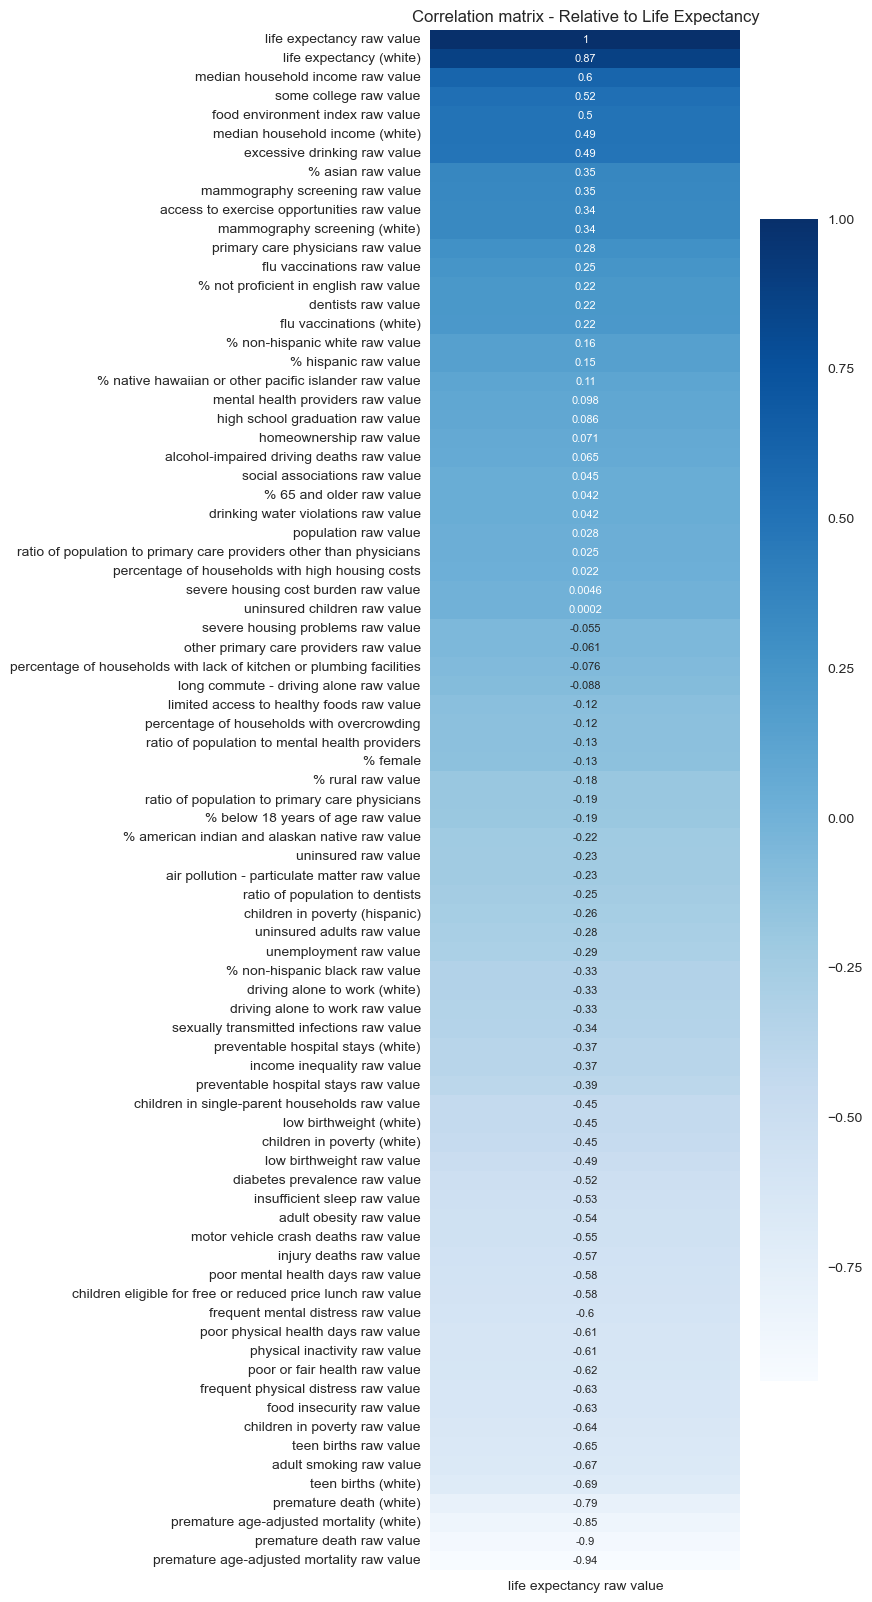

In [185]:
plt.figure(figsize=(5, 20))

sns.heatmap(p[['life expectancy raw value']].sort_values(by='life expectancy raw value', ascending=False), 
            annot=True, 
            cmap='Blues', 
            annot_kws={"size": 8})

plt.title("Correlation matrix - Relative to Life Expectancy")
plt.show()

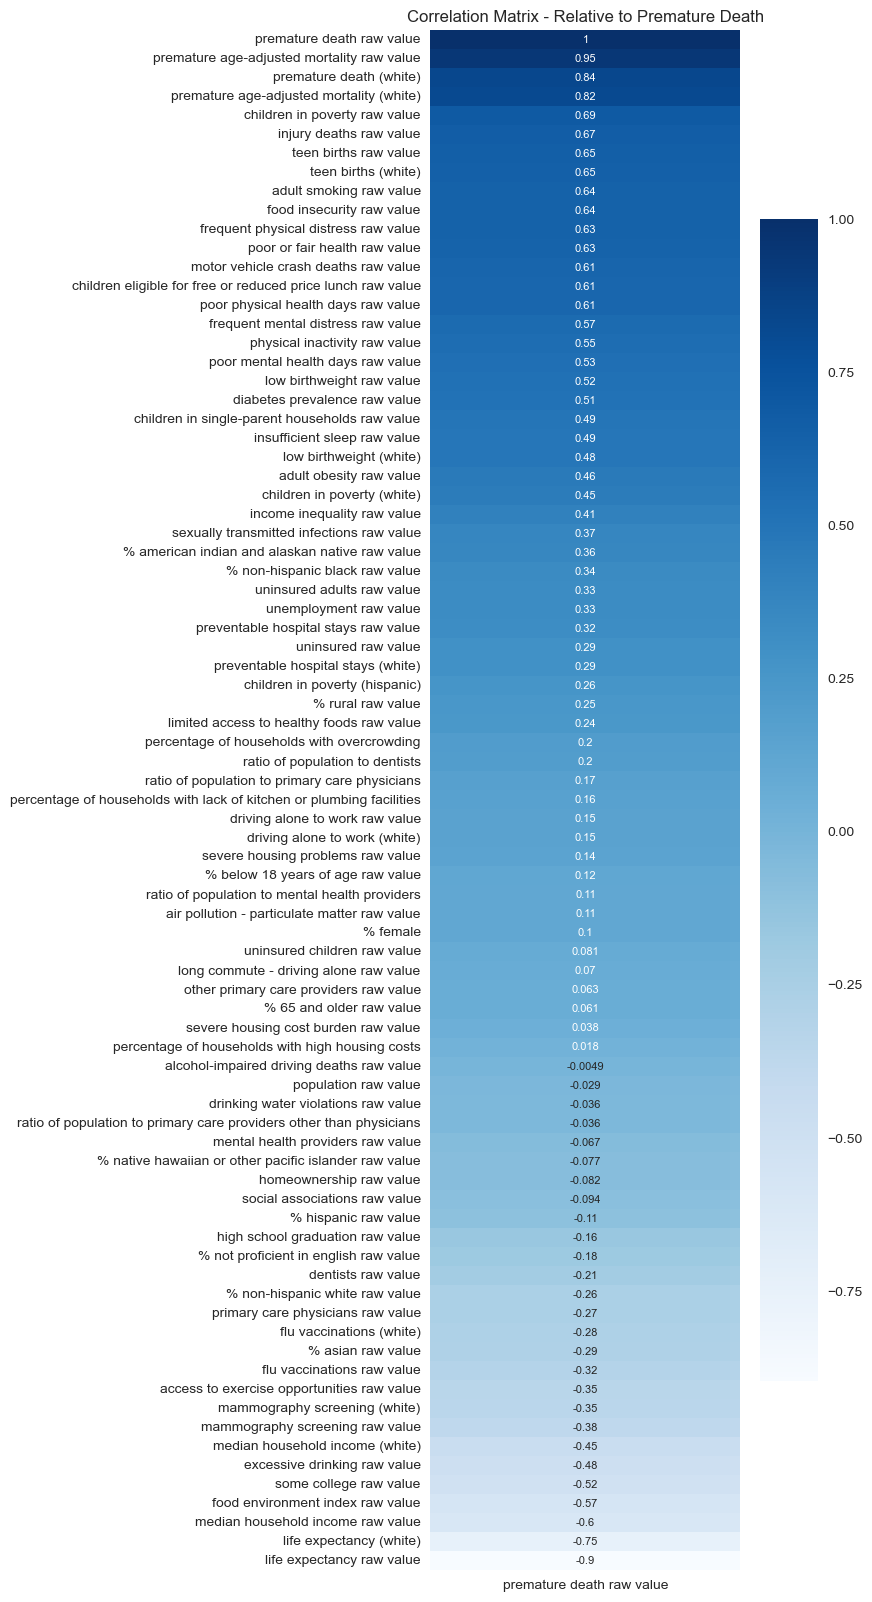

In [186]:
plt.figure(figsize=(5, 20))

sns.heatmap(p[['premature death raw value']].sort_values(by='premature death raw value', ascending=False), 
            annot=True, 
            cmap='Blues',
            annot_kws={"size": 8})

plt.title("Correlation Matrix - Relative to Premature Death")
plt.show()

From these plots, we can see that life_expectancy(white) is highly correlated with our outcome. This is not surprising as our outcome is a function of this variable. Additionally, premature death data is also highly correlated with our outcome. Because of this, we will only look at overall life expectancy as our target, and remove the life expectancy (white) feature and all premature death features as a predictor.

Additionally, we see negative correlations in household income, college education, and high school graduation rates.

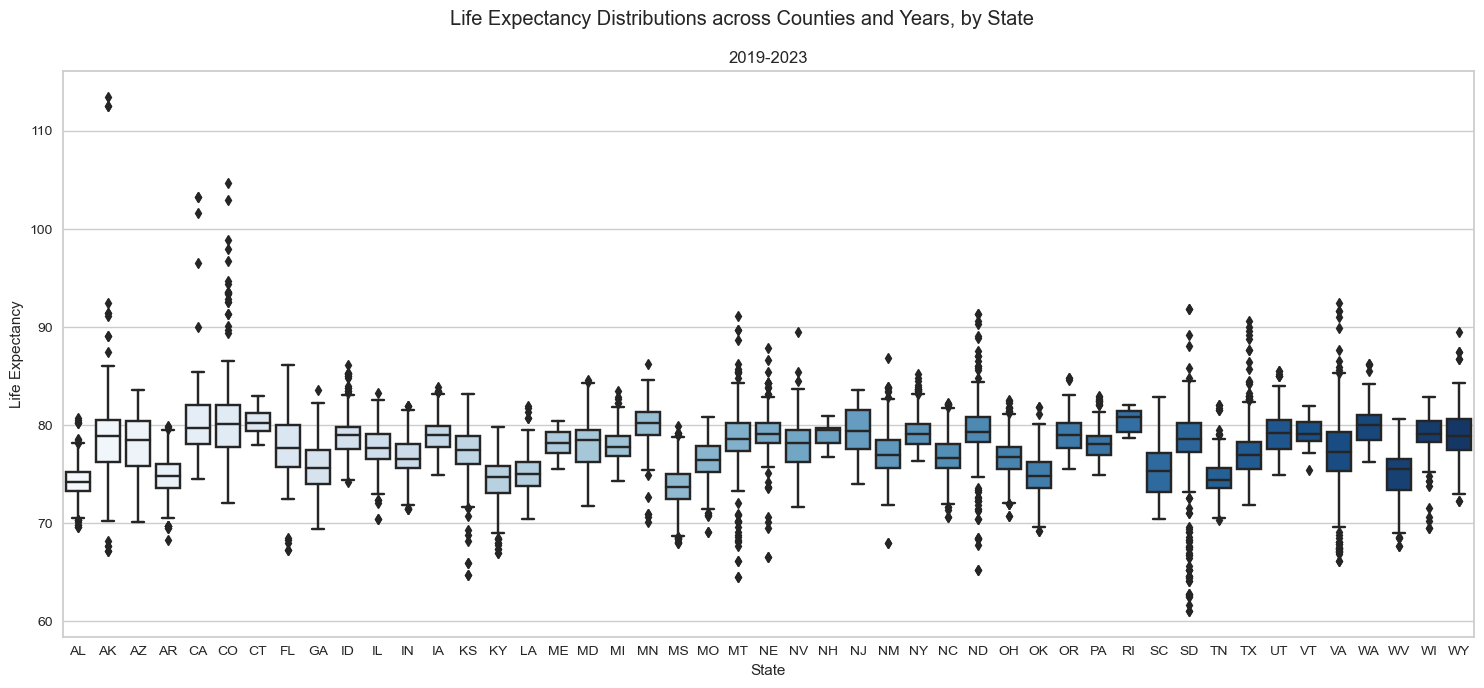

In [191]:
plt.figure(figsize=(15, 7))

sns.boxplot(data=df, x='state abbreviation', y='life expectancy raw value', palette="Blues")

plt.suptitle("Life Expectancy Distributions across Counties and Years, by State")
plt.title("2019-2023")
plt.ylabel("Life Expectancy")
plt.xlabel("State")

plt.tight_layout()

plt.savefig('../figures/boxplot.png')
plt.show()

Although our goal is to look at counties, it would be very difficult to visualize these distributions for EDA since there are over 3000 counties. For that reason we created box plots of life expectancy across each state. This still provides us with a general overview of our data, before we can dive into more of the county-specific information. From this plot we can see that the distributions vary alot between states in terms of spread and number of outliers. If data varies this much among states,it likely varies more between counties.

### 1.4 Data modelling

In [192]:
df = pd.read_csv('../data/df_clean.csv', index_col=[0, 1, 2, 3, 4, 5])
df.head(3)

% 65 and older raw value  \
state fips code county fips code 5-digit fips code state abbreviation name           release year                             
1               1                1001              AL                 Autauga County 2019                          0.151196   
                3                1003              AL                 Baldwin County 2019                          0.199470   
                5                1005              AL                 Barbour County 2019                          0.188247   

                                                                                                   % below 18 years of age raw value  \
state fips code county fips code 5-digit fips code state abbreviation name           release year                                      
1               1                1001              AL                 Autauga County 2019                                   0.239370   
                3                1003              AL                 Baldwin County 2019                                   0.218485   
                5                1005              AL                 Barbour County 2019                                   0.207638   

                                                                                                   % female  \
state fips code county fips code 5-digit fips code state abbreviation name           release year             
1               1                1001              AL                 Autauga County 2019          0.513422   
                3                1003              AL                 Baldwin County 2019          0.514528   
                5                1005              AL                 Barbour County 2019          0.472299   

                                                                                                   % not proficient in english raw value  \
state fips code county fips code 5-digit fips code state abbreviation name           release year                                          
1               1                1001              AL                 Autauga County 2019                                       0.008285   
                3                1003              AL                 Baldwin County 2019                                       0.004545   
                5                1005              AL                 Barbour County 2019                                       0.011993   

                                                                                                   % rural raw value  \
state fips code county fips code 5-digit fips code state abbreviation name           release year                      
1               1                1001              AL                 Autauga County 2019                   0.420022   
                3                1003              AL                 Baldwin County 2019                   0.422791   
                5                1005              AL                 Barbour County 2019                   0.677896   

                                                                                                   access to exercise opportunities raw value  \
state fips code county fips code 5-digit fips code state abbreviation name           release year                                               
1               1                1001              AL                 Autauga County 2019                                            0.686775   
                3                1003              AL                 Baldwin County 2019                                            0.719710   
                5                1005              AL                 Barbour County 2019                                            0.536257   

                                                                                                   adult obesity raw value  \
state fips code county fips code 5-digit fips code state abbreviation na

#### Pre-Processing

##### Train-test split

It is important here to recognize that there are multiple variables that are indicators for life expectancy and premature death, but they differentiate by race and indicate data quality. Our model will not generalize well if we include, for instance, `Life Expectancy (white)` as a predictor for `Life Expectancy`. Therefore, we will create a matrix $Y$ with all outcome variables of interest and select specific vectors $y$ when we go to train our models. Below, we collect the outcome variables of interest. 

In [203]:
# Example: df = df[df.columns.drop(list(df.filter(regex='ci low')))]

life_exp_cols = list(df.filter(regex='life expectancy').columns)
prem_death_cols = list(df.filter(regex='premature death').columns)
target_vars = life_exp_cols + prem_death_cols + ['quality of life']
print(target_vars)

['life expectancy raw value', 'premature death raw value', 'quality of life']


In [204]:
# Check for indicator/dummy variables
list(df.filter(regex='flag').columns)

[]

In [205]:
# create matrices X and Y (description above)
X = df.loc[: , df.columns.difference(target_vars)]
Y = df.loc[:, target_vars]

# Separate train and test data
X_train, X_test, Y_train, Y_test = train_test_split(
    X, 
    Y,
    test_size=TEST_SIZE,
    random_state=SEED
)

# Print matrix Y_test first five rows
Y_test.head()

,life expectancy raw value,premature death raw value,quality of life
3432,79.875300,6399.783439,3.283773
2155,76.364520,9649.676199,4.713736
8120,77.771010,8476.333298,4.301731
11492,76.929847,7532.152726,4.886971
1768,82.455908,4359.466577,2.961102


##### Scaling

As we confirmed above, there are no additional dummy/indicator variables apart from the data quality indicators we put into our matrix $Y$. Therefore, the primary pre-processing we have to do is to scale our data.

We want to fit our scaler on our training data only, so we do not leak any information about the distribution of our test data into our training stage. We therefore perform a `fit_transform()` on the training data and then simply a `tranform()` on the test data, which ensures that the mean and sd parameters learned when we fit the scaler are only from the train dataset.

In [29]:
scaler = StandardScaler()

In [30]:
# Scale X_train
X_train_scale = pd.DataFrame(
    scaler.fit_transform(X_train),
    columns=X_train.columns
)

X_train_scale.head()

,% 65 and older raw value,% american indian and alaskan native raw value,% asian raw value,% below 18 years of age raw value,% female,% hispanic raw value,% native hawaiian or other pacific islander raw value,% non-hispanic black raw value,% non-hispanic white raw value,% not proficient in english raw value,...,some college raw value,teen births (black),teen births (hispanic),teen births (white),teen births raw value,unemployment raw value,uninsured adults raw value,uninsured children raw value,uninsured raw value,year
0,3.584541,0.610756,-0.371596,-1.937958,-2.229175,0.637596,-0.028442,-0.378712,-0.425954,0.819200,...,-1.324167,0.057820,-0.329844,0.389879,0.174958,0.007647,0.241451,1.470172,0.475003,-0.709008
1,-0.612182,0.127163,0.474257,1.381683,-0.500903,2.461427,0.108579,-0.567557,-1.312509,2.693026,...,-1.102304,-1.328650,-0.985897,-0.672456,-0.489371,1.036896,0.248566,-0.122907,0.124251,1.413455
2,-0.117095,-0.237681,-0.237156,-0.566892,0.428058,-0.432156,-0.076161,-0.080089,0.436654,-0.586766,...,0.034257,-0.585411,-0.358008,-0.492293,-0.876845,-1.059384,-0.395011,-0.323600,-0.366016,-0.709008
3,0.844268,-0.244080,-0.148247,-0.731017,0.438541,-0.247980,-0.085618,2.380572,-1.374165,-0.220828,...,-0.738523,0.253828,0.144710,0.447219,-0.370278,-0.051707,1.029990,0.594760,1.092369,-0.001520
4,-2.162803,-0.215573,0.196826,1.736929,-0.227448,0.213298,0.501043,2.317142,-1.851322,-0.053417,...,0.701481,0.784154,0.611162,4.214630,2.040974,-0.255711,0.237441,-0.209727,0.102060,-0.709008


In [31]:
#Scale X_test
X_test_scale = pd.DataFrame(
    scaler.transform(X_test),
    columns=X_train.columns
)

X_test.head()

,,,,,,% 65 and older raw value,% american indian and alaskan native raw value,% asian raw value,% below 18 years of age raw value,% female,% hispanic raw value,% native hawaiian or other pacific islander raw value,% non-hispanic black raw value,% non-hispanic white raw value,% not proficient in english raw value,...,some college raw value,teen births (black),teen births (hispanic),teen births (white),teen births raw value,unemployment raw value,uninsured adults raw value,uninsured children raw value,uninsured raw value,year
state fips code,county fips code,5-digit fips code,state abbreviation,name,release year,,,,,,,,,,,,,,,,,,,,,
51,840,51840,VA,Winchester city,2021,0.163829,0.008726,0.027210,0.224731,0.508085,0.182598,0.001211,0.105136,0.657098,0.053641,...,0.630419,30.646992,36.891680,19.493614,23.820092,0.027666,0.173860,0.059840,0.142026,2021
48,111,48111,TX,Dallam County,2023,0.118098,0.025237,0.016592,0.328221,0.471138,0.476157,0.001394,0.018684,0.476994,0.184264,...,0.524742,36.956227,83.056478,43.193717,68.233945,0.026295,0.370101,0.251455,0.326187,2023
1,37,1037,AL,Coosa County,2019,0.227636,0.005858,0.001488,0.164032,0.498047,0.024270,0.001674,0.301748,0.657709,0.005394,...,0.449612,45.691906,51.980659,46.090535,45.273632,0.046228,0.160698,0.038001,0.133439,2019
20,87,20087,KS,Jefferson County,2022,0.201555,0.010088,0.002995,0.224727,0.492697,0.030633,0.001471,0.006620,0.932114,0.001282,...,0.706208,31.669330,41.806638,17.241379,16.912298,0.048888,0.108382,0.056945,0.093387,2022
31,109,31109,NE,Lancaster County,2022,0.148221,0.010157,0.046883,0.225040,0.498185,0.076064,0.001063,0.040764,0.803493,0.022295,...,0.768298,31.459306,39.023021,9.511450,13.698800,0.042366,0.095854,0.046281,0.081676,2022


#### Linear Regression

In [32]:
def r2_adj(model, X, y):
    """
    1-(1-R2)*(n-1)/(n-p-1)
    Source: https://stackoverflow.com/questions/51038820/how-to-calculated-the-adjusted-r2-value-using-scikit
    
    Params:
        model: Fitted model
        X: Explanatory variables
        y: Target values
    Returns:
        r2_adj: Adjusted R2 value
    """
    n = X.shape[0]
    p = X.shape[-1]
    r2 = model.score(X, y)
    r2_adj = 1 - (1 - r2) * (n - 1) / (n - p - 1)
    return r2_adj

def display_linear_regression_metrics(model, X_train, y_train, X_test, y_test):
    """
    Display linear regression metrics
    """
    # Generate predictions
    y_test_pred = model.predict(X_test)
    y_train_pred = model.predict(X_train)
    
    # Display values
    print("----------------------------------------")
    print(f"MSE (test):     {mean_squared_error(y_test, y_test_pred):,.2f}")
    print(f"Adj R2 (test):  {r2_adj(model, X_test_scale, y_test):.3f}") 
    print(f"R2 (test):      {model.score(X_test_scale, y_test):.3f}")
    print(f"MSE (train):    {mean_squared_error(y_train, y_train_pred):,.2f}")
    print(f"Adj R2 (train): {r2_adj(model, X_train_scale, y_train):.3f}") 
    print(f"R2 (train):     {model.score(X_train_scale, y_train):.3f}")
    print("----------------------------------------")


As an initial step, we want to start by fitting a very simple linear regression model to our data.

In [33]:
# Initialize linear regression model
lm = LinearRegression()

# Select life expectancy as our target value for this model
y_train = Y_train[['life expectancy raw value']]
y_test = Y_test[['life expectancy raw value']]

# Fit model
lm.fit(X_train_scale, y_train)

# Display metrics
display_linear_regression_metrics(
    model=lm,
    X_train=X_train_scale,
    y_train=y_train,
    X_test=X_test_scale,
    y_test=y_test,
)

----------------------------------------
MSE (test):     1.16
Adj R2 (test):  0.875
R2 (test):      0.879
MSE (train):    1.19
Adj R2 (train): 0.879
R2 (train):     0.880
----------------------------------------


As an initial model, we get a relatively good fit, and we don't seem to be overfitting. However, there can likely be improvement.

### 1.5 Conclusion 

- Overall, our county-level data on on health behaviors, clinical care, socioeconomic factors, and physical environment spans 5 years.
- Our research questions consist of a mix between supervised and unsupervised models.

#### Refined Questions & Target Variables

1. **How can we predict life expectancy and which factors are most influential in this prediction?**
    - The target variable for this question is 'life expectancy raw value'
2. **How can we predict quality of life and which factors are most influential in this prediction (i.e., physical and mental health)?**
    - Within our dataset, there are a few variables that indicate quality of life (Based on the data documention). We will choose to create an average of the two variables that factor in both mental and physical health as our measure for quality of life. Hence our outcome here is the variable 'quality of life'
3. **How do predictors differ across states and years? Are there groups of states with similar characteristics/factors?**
    - This question does not have a target variable as we will be using unsupervised models.



### 1.6 References 

- Lecture 1-21
- Labs 1-10
- Homeworks 1-2
- Midterm 
- https://stackoverflow.com/questions/19071199/drop-columns-whose-name-contains-a-specific-string-from-pandas-dataframe 
- https://stackoverflow.com/questions/51038820/how-to-calculated-the-adjusted-r2-value-using-scikit

Thanks!

### Other